In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [349]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

In [350]:
def ensure_nasdaq(df):
	##check headdings are correct:
	if 'Date' not in df.columns:
		raise ValueError("The data does not contain the Date column.")

	if 'Open' not in df.columns:
		raise ValueError("The data does not contain the Open column.")
	
	if 'Close/Last' not in df.columns:
		raise ValueError("The data does not contain the Close column.")
		
	if 'High' not in df.columns:
		raise ValueError("The data does not contain the High column.")
	
	if 'Low' not in df.columns:
		raise ValueError("The data does not contain the Low column.")

	if 'Volume' not in df.columns:
		raise ValueError("The data does not contain the Volume column.")
	

	print("Data is in the correct format and likely origins from nasdaq.com")

	return True

In [351]:
def translate_data(path):
	data = pd.read_csv(path)
	# Ensure that the data is from nasdaq.com
 
	if(not ensure_nasdaq(data)):
		raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")
		return None


	# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
	data['Date'] = pd.to_datetime(data['Date'])
	data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
	data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
	data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
	data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)


	# inverse the entire dataframe
 
	data = data.iloc[::-1]

	# reset the index

	data = data.reset_index(drop=True)



	return data

In [352]:
data = translate_data("csvs/stocks/tsla/tsla.csv")

Data is in the correct format and likely origins from nasdaq.com


In [353]:
data

,Date,Close/Last,Volume,Open,High,Low
0,2014-04-23,13.8660,109026530,14.4220,14.4493,13.8000
1,2014-04-24,13.8573,82375159,14.0540,14.1867,13.5467
2,2014-04-25,13.3233,104721848,13.4667,13.7800,13.1767
3,2014-04-28,13.2340,105504802,13.3333,13.5860,12.7000
4,2014-04-29,13.7947,86658452,13.2140,13.8099,13.0353
...,...,...,...,...,...,...
2512,2024-04-16,157.1100,96999960,156.7420,158.1900,153.7500
2513,2024-04-17,155.4500,82439720,157.6400,158.3300,153.7800
2514,2024-04-18,149.9300,96098830,151.2500,152.2000,148.7000
2515,2024-04-19,147.0500,87074500,148.9700,150.9400,146.2200


In [354]:
def build_data(df):
	lags = 4

	names = []

	df['returns'] = np.log(df['Close/Last'].pct_change() + 1)

	for i in range(1, lags+1):
		df[f'lag_{i}'] = df['returns'].shift(i)

		names.append(f'lag_{i}')

	df.dropna(inplace=True)

	return df, names



In [355]:
data, lagnames = build_data(data)

In [356]:
model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None)

In [357]:
Train, Test = train_test_split(data, test_size=0.2, shuffle=False, random_state=42)

In [358]:
Train

,Date,Close/Last,Volume,Open,High,Low,returns,lag_1,lag_2,lag_3,lag_4
5,2014-04-30,13.8593,66482412,13.5733,13.8773,13.4187,0.004672,0.041495,-0.006725,-0.039298,-0.000628
6,2014-05-01,13.8487,81526999,13.8053,14.2680,13.7127,-0.000765,0.004672,0.041495,-0.006725,-0.039298
7,2014-05-02,14.0607,61231619,13.9067,14.0907,13.7680,0.015192,-0.000765,0.004672,0.041495,-0.006725
8,2014-05-05,14.4407,77120601,13.9653,14.5127,13.9013,0.026667,0.015192,-0.000765,0.004672,0.041495
9,2014-05-06,13.8187,84300903,14.4400,14.5773,13.7900,-0.044028,0.026667,0.015192,-0.000765,0.004672
...,...,...,...,...,...,...,...,...,...,...,...
2009,2022-04-13,340.7900,55121226,327.0250,342.0800,324.3656,0.035259,0.011228,-0.049535,-0.030510,0.010937
2010,2022-04-14,328.3333,58422426,333.0966,337.5699,327.3966,-0.037237,0.035259,0.011228,-0.049535,-0.030510
2011,2022-04-18,334.7633,51715235,329.6766,338.3066,324.4700,0.019394,-0.037237,0.035259,0.011228,-0.049535
2012,2022-04-19,342.7166,49847825,335.0200,344.9800,331.7750,0.023480,0.019394,-0.037237,0.035259,0.011228


In [359]:
Test

,Date,Close/Last,Volume,Open,High,Low,returns,lag_1,lag_2,lag_3,lag_4
2014,2022-04-21,336.2600,105416351,358.2433,364.0733,332.1383,0.031806,-0.050825,0.023480,0.019394,-0.037237
2015,2022-04-22,335.0166,69696577,338.3033,344.9500,331.3333,-0.003705,0.031806,-0.050825,0.023480,0.019394
2016,2022-04-25,332.6733,68341357,326.3233,336.2066,325.1000,-0.007019,-0.003705,0.031806,-0.050825,0.023480
2017,2022-04-26,292.1400,136133684,331.8100,333.3333,291.6666,-0.129928,-0.007019,-0.003705,0.031806,-0.050825
2018,2022-04-27,293.8366,76956398,299.5266,306.0000,292.4533,0.005791,-0.129928,-0.007019,-0.003705,0.031806
...,...,...,...,...,...,...,...,...,...,...,...
2512,2024-04-16,157.1100,96999960,156.7420,158.1900,153.7500,-0.027435,-0.057575,-0.020542,0.016399,-0.029373
2513,2024-04-17,155.4500,82439720,157.6400,158.3300,153.7800,-0.010622,-0.027435,-0.057575,-0.020542,0.016399
2514,2024-04-18,149.9300,96098830,151.2500,152.2000,148.7000,-0.036156,-0.010622,-0.027435,-0.057575,-0.020542
2515,2024-04-19,147.0500,87074500,148.9700,150.9400,146.2200,-0.019396,-0.036156,-0.010622,-0.027435,-0.057575


In [360]:
model.fit(Train[lagnames], Train['returns'])

LinearRegression()

In [361]:


Test['predicted_return'] = model.predict(Test[lagnames])
Test['predicted_direction'] = [1 if i > 0 else -1 for i in Test['predicted_return']]
Test['strategy_returns'] = Test['predicted_direction'] * Test['returns']

In [362]:
np.exp(Test[['returns', 'strategy_returns']].sum())

returns             0.436093
strategy_returns    0.220796
dtype: float64

<Axes: >

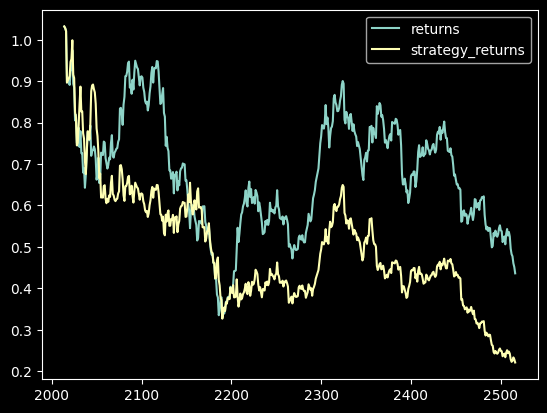

In [363]:
np.exp(Test[['returns', 'strategy_returns']].cumsum()).plot()

In [364]:
Test

,Date,Close/Last,Volume,Open,High,Low,returns,lag_1,lag_2,lag_3,lag_4,predicted_return,predicted_direction,strategy_returns
2014,2022-04-21,336.2600,105416351,358.2433,364.0733,332.1383,0.031806,-0.050825,0.023480,0.019394,-0.037237,0.003727,1,0.031806
2015,2022-04-22,335.0166,69696577,338.3033,344.9500,331.3333,-0.003705,0.031806,-0.050825,0.023480,0.019394,0.000259,1,-0.003705
2016,2022-04-25,332.6733,68341357,326.3233,336.2066,325.1000,-0.007019,-0.003705,0.031806,-0.050825,0.023480,0.000275,1,-0.007019
2017,2022-04-26,292.1400,136133684,331.8100,333.3333,291.6666,-0.129928,-0.007019,-0.003705,0.031806,-0.050825,0.003615,1,-0.129928
2018,2022-04-27,293.8366,76956398,299.5266,306.0000,292.4533,0.005791,-0.129928,-0.007019,-0.003705,0.031806,0.000390,1,0.005791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2024-04-16,157.1100,96999960,156.7420,158.1900,153.7500,-0.027435,-0.057575,-0.020542,0.016399,-0.029373,0.002067,1,-0.027435
2513,2024-04-17,155.4500,82439720,157.6400,158.3300,153.7800,-0.010622,-0.027435,-0.057575,-0.020542,0.016399,-0.001362,-1,0.010622
2514,2024-04-18,149.9300,96098830,151.2500,152.2000,148.7000,-0.036156,-0.010622,-0.027435,-0.057575,-0.020542,-0.000790,-1,0.036156
2515,2024-04-19,147.0500,87074500,148.9700,150.9400,146.2200,-0.019396,-0.036156,-0.010622,-0.027435,-0.057575,0.001581,1,-0.019396


In [365]:
Train

,Date,Close/Last,Volume,Open,High,Low,returns,lag_1,lag_2,lag_3,lag_4
5,2014-04-30,13.8593,66482412,13.5733,13.8773,13.4187,0.004672,0.041495,-0.006725,-0.039298,-0.000628
6,2014-05-01,13.8487,81526999,13.8053,14.2680,13.7127,-0.000765,0.004672,0.041495,-0.006725,-0.039298
7,2014-05-02,14.0607,61231619,13.9067,14.0907,13.7680,0.015192,-0.000765,0.004672,0.041495,-0.006725
8,2014-05-05,14.4407,77120601,13.9653,14.5127,13.9013,0.026667,0.015192,-0.000765,0.004672,0.041495
9,2014-05-06,13.8187,84300903,14.4400,14.5773,13.7900,-0.044028,0.026667,0.015192,-0.000765,0.004672
...,...,...,...,...,...,...,...,...,...,...,...
2009,2022-04-13,340.7900,55121226,327.0250,342.0800,324.3656,0.035259,0.011228,-0.049535,-0.030510,0.010937
2010,2022-04-14,328.3333,58422426,333.0966,337.5699,327.3966,-0.037237,0.035259,0.011228,-0.049535,-0.030510
2011,2022-04-18,334.7633,51715235,329.6766,338.3066,324.4700,0.019394,-0.037237,0.035259,0.011228,-0.049535
2012,2022-04-19,342.7166,49847825,335.0200,344.9800,331.7750,0.023480,0.019394,-0.037237,0.035259,0.011228
